In [1]:
import pandas as pd
import numpy as np
from datetime import date
from dateutil import relativedelta as rd

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

import seaborn as sns
sns.set_style("whitegrid")

from helpers import utils
from app import data_loader as dl
from app import evaluate, metrics

In [2]:
period_start = date(1958, 3, 1)
period_end = date(1959, 2, 1)
data = (
    dl.load_data()
)
data.head()

,passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [3]:
def get_period_observations(df, period_start, period_end):
    return (
        df.copy()
        [period_start:period_end]
        .reset_index()
        .rename(columns={'Month': 'month', 'passengers': 'y_true'})
    )
    
get_period_observations(data, period_start, period_end)

,month,y_true
0,1958-03-01,362
1,1958-04-01,348
2,1958-05-01,363
3,1958-06-01,435
4,1958-07-01,491
5,1958-08-01,505
6,1958-09-01,404
7,1958-10-01,359
8,1958-11-01,310
9,1958-12-01,337


In [5]:
def make_future_index(period_start, horizon=12):
    return pd.date_range(period_start, periods=horizon, freq='MS')

make_future_index(period_start)

DatetimeIndex(['1958-03-01', '1958-04-01', '1958-05-01', '1958-06-01',
               '1958-07-01', '1958-08-01', '1958-09-01', '1958-10-01',
               '1958-11-01', '1958-12-01', '1959-01-01', '1959-02-01'],
              dtype='datetime64[ns]', freq='MS')

In [6]:
class Naive(object):
    def fit(self, df):
        self.train_data = df
        
    def predict(self, idx):
        return pd.Series(np.repeat(self.train_data.iloc[-1].passengers, len(idx)), index=idx)


In [7]:
class SeasonalNaive(object):
    def fit(self, df):
        self.train_data = df
        
    def predict(self, idx):
        return pd.Series(self.train_data[-12:].passengers.values, index=idx)


In [8]:
class MovingAverage(object):
    def __init__(self, window=12):
        self.window = window
        
    def fit(self, df):
        self.train_data = df
        
    def predict(self, idx):
        return pd.Series(self.train_data.rolling(window=self.window, center=False).mean().iloc[-12:].passengers.values, index=idx)


In [9]:
def bias(x):
    if x > 0:
        return 1
    elif x < 0:
        return -1
    else:
        return 0

In [10]:
def generate_evaluation_set(df, period_start, period_end, model):
    def calc_months_diff(x):
        return rd.relativedelta(x.month, x.forecast_start).months + 1
    
    def get_train_data(df, forecast_start):
        return (
            df.copy()
            [:forecast_start - rd.relativedelta(months=1)]
        )
    
    def add_observations(result):
        return (
            pd.merge(result, get_period_observations(df, period_start, period_end), on=['month'], how='inner')
            .assign(error = lambda x: x.y_pred - x.y_true)
            .assign(bias = lambda x: x.error.map(bias))
        )
    
    horizon = 12
        
    results = pd.DataFrame(None, columns=['month', 'y_true', 'y_pred'])
    
    for run_num in range(0, horizon):
        forecast_start = period_start + rd.relativedelta(months=run_num)
        train = get_train_data(df, forecast_start)
        future = make_future_index(forecast_start, horizon)
        
        model.fit(train)
        estimates = model.predict(future)
        
        result = (
            pd.DataFrame({
                'month': future.values,
                'y_pred': estimates
            }, index=future)
            .assign(forecast_start = lambda x: pd.to_datetime(forecast_start))
            .assign(horizon = lambda x: x.apply(calc_months_diff, axis=1))
        )
        
        result = add_observations(result)
        
        results = pd.concat([results, result])
    
    return results

In [11]:
df = generate_evaluation_set(data, period_start, period_end, Naive())
# df.to_csv(utils.get_processed_file('naive_evaluation.csv'), index=False)
df.sample(n=4)

,bias,error,forecast_start,horizon,month,y_pred,y_true
2,1.0,132.0,1958-08-01,3.0,1958-10-01,491,359
5,-1.0,-187.0,1958-03-01,6.0,1958-08-01,318,505
6,1.0,3.0,1958-04-01,7.0,1958-10-01,362,359
2,-1.0,-142.0,1958-06-01,3.0,1958-08-01,363,505


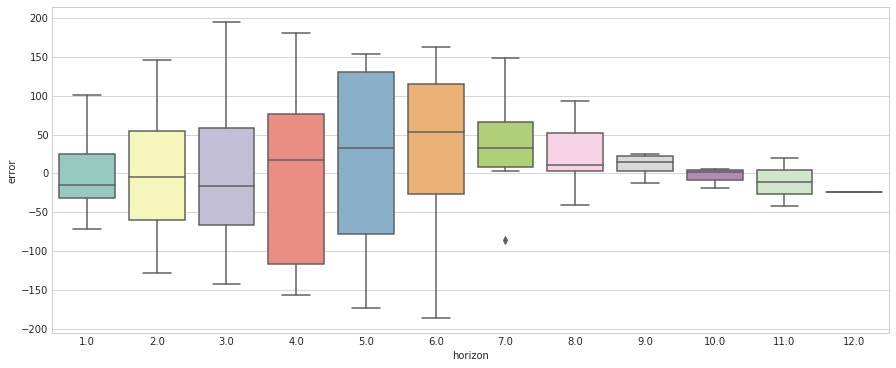

In [12]:
def plot_horizon_variance(df):
    sns.boxplot(x="horizon", y="error", data=df, palette="Set3")
    plt.show();

plot_horizon_variance(df)

In [13]:
forecast = df[df.forecast_start == period_start]
forecast.head()

,bias,error,forecast_start,horizon,month,y_pred,y_true
0,-1.0,-44.0,1958-03-01,1.0,1958-03-01,318,362
1,-1.0,-30.0,1958-03-01,2.0,1958-04-01,318,348
2,-1.0,-45.0,1958-03-01,3.0,1958-05-01,318,363
3,-1.0,-117.0,1958-03-01,4.0,1958-06-01,318,435
4,-1.0,-173.0,1958-03-01,5.0,1958-07-01,318,491


In [14]:
def build_period_score(df):
    return (
        df
        .groupby(['forecast_start'])
        .agg({
            'y_pred': np.sum,
            'y_true': np.sum,
        })
        .reset_index()
        .assign(mape = lambda x: evaluate.mean_absolute_percentage_error(x.y_true, x.y_pred))
        .assign(mae = lambda x: mean_absolute_error(x.y_true, x.y_pred))
        .assign(rmse = lambda x: np.sqrt(mean_squared_error(x.y_true, x.y_pred)))
        .assign(bias = lambda x: (x.y_pred - x.y_true).map(bias))
    )

build_period_score(forecast)

AttributeError: module 'app.evaluate' has no attribute 'mean_absolute_percentage_error'

In [ ]:
def build_horizon_score(df, group='horizon'):
    def aggregate(x):
        return pd.Series({
            'mape': evaluate.mean_absolute_percentage_error(x.y_true, x.y_pred),
            'mae': mean_absolute_error(x.y_true, x.y_pred),
            'rmse': np.sqrt(mean_squared_error(x.y_true, x.y_pred)),
            'observations': x.y_true.count(),
            'bias': x.bias.sum() / x.bias.count()
        })
    
    return (
        df
        .groupby([group])
        .apply(aggregate)
        .reset_index()
    )

build_horizon_score(df)

In [ ]:
build_horizon_score(forecast)

In [ ]:
def plot_horizon_score(df):
    df.plot(x='horizon', y='mape')
    plt.show();

plot_horizon_score(build_horizon_score(forecast))

In [ ]:
def plot_horizon_bias(df):
    sns.barplot(x='horizon', y='bias', data=df, color='b')
    plt.show();
    
plot_horizon_bias(forecast)

In [ ]:
sns.barplot(x="horizon", y="error", data=forecast);

In [ ]:
def plot_month_score(df, horizon=1):
    months = (
        build_horizon_score(df[df.horizon == horizon], 'forecast_start')
        .assign(start_month = lambda x: x.forecast_start.dt.strftime('%b'))
        .assign(month = lambda x: x.forecast_start.dt.month)
        .sort_values(['month'])
    )
    sns.barplot(x='start_month', y='mape', data=months)
    
plot_month_score(df, 1)

In [ ]:
def plot_horizon_score(df):
    sns.barplot(x="horizon", y="mape", data=build_horizon_score(df))
    plt.show();
    
plot_horizon_score(df)